In [41]:
flex_source_link = "https://github.com/et22"

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import ipywidgets as widgets
from scipy.io import loadmat
from IPython.display import display, Markdown, clear_output
from ipywidgets import interact, interactive, interactive_output
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import ipywidgets as widgets
import scipy
import matplotlib
import sklearn
from IPython.display import clear_output, display
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import resample

from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.stats import chi2_contingency, ttest_ind,ttest_1samp, spearmanr
                 
from tempfile import TemporaryFile
from random import randint
#import networkx as nx
#from pyvis.network import Network

import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

np.random.seed(42)


In [793]:
resample(np.array([1,2,3,4,5]))

array([2, 3, 3, 3, 5])

In [2]:
# define config
class structtype():
    pass

config = structtype()
config.deploy_flag = 0

def set_axis_defaults():
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# define cat variable labels
labels = {'cl': ["2/3", "4a/b", "4cα", "4cβ", "5", "6", "WM"], 
         'sc': ["Com.", "Sim."],
         'ct': ["AS", "FS", "RM", "RL"]}

In [3]:
def make_cont_mtx(cat_row, cat_col, cont, num_rows):
    cat_rows = np.arange(num_rows)+1
    cat_cols = np.arange(num_rows)+1
    cont_mtx = np.zeros((cat_rows.size, cat_cols.size))
    for idxr, row in np.ndenumerate(cat_rows):
        for idxc, col in np.ndenumerate(cat_cols):
            cont_mtx[idxr, idxc] = np.nanmean(cont[np.logical_and(cat_row == row,cat_col == col)]);
    return cont_mtx;

def make_prop_mtx(cat_row, cat_col, numer_var, num_rows):
    cat_rows = np.arange(num_rows)+1
    cat_cols = np.arange(num_rows)+1
    prop_numer = np.zeros((cat_rows.size, cat_cols.size))
    prop_denom = np.zeros((cat_rows.size, cat_cols.size))
    for idxr, row in np.ndenumerate(cat_rows):
        for idxc, col in np.ndenumerate(cat_cols):
            subset = np.logical_and(cat_row == row,cat_col == col)
            rev_subset = np.logical_and(cat_row == col, cat_col == row)
            either_subset = np.logical_or(subset, rev_subset)
            prop_numer[idxr, idxc] = np.nansum(numer_var[subset])
            prop_denom[idxr, idxc] = np.size(numer_var[subset])
            
    prop_mtx = np.divide(prop_numer, prop_denom)
    return prop_mtx, prop_numer, prop_denom

def get_checkbox_inclusions(boxes, pre_tlabels, post_tlabels):
    subset = np.ones_like(pre_tlabels, dtype='bool')
    for idx, box in enumerate(boxes):
        if not box.value:
            ex_val = idx + 1
            subset = np.logical_and.reduce((subset, pre_tlabels!=ex_val, post_tlabels!=ex_val))
    return subset

def get_subset(change):
    metric = ccg_selection.value
    
    maxima = maxima_selection.value
    lag_max = lag_selection.value[1]
    lag_min = lag_selection.value[0]
    
    std_max = std_selection.value[1]
    std_min = std_selection.value[0]
    
    area_max = area_selection.value[1]
    area_min = area_selection.value[0]
    
    ccg_curr = ccg_data[metric][0][0].copy()
    ccg_fields = ccg_data['ccg'][0][0].dtype.names
    
    
    noise_std = ccg_curr['noise_std' + noise_selection.value]
    noise_mean = ccg_curr['noise_mean' + noise_selection.value]
    
    lag_subset = np.logical_and(ccg_curr[maxima+'_lag']>=lag_min, ccg_curr[maxima+'_lag']<=lag_max)
    maxima_subset = np.logical_and(ccg_curr[maxima+'s']>=(std_min*noise_std+noise_mean), ccg_curr[maxima+'s']<=(std_max*noise_std+noise_mean)) 
    area_subset = np.logical_and(ccg_curr['area']>=area_min, ccg_curr['area']<=area_max)    
    
    cl_subset = get_checkbox_inclusions(cl_checkboxes[1:],ccg_curr['pre_cl'],ccg_curr['post_cl'])
    ct_subset = get_checkbox_inclusions(ct_checkboxes[1:],ccg_curr['pre_ct'],ccg_curr['post_ct'])
    sc_subset = get_checkbox_inclusions(sc_checkboxes[1:],ccg_curr['pre_sc'],ccg_curr['post_sc'])

    subset = np.logical_and.reduce((lag_subset, maxima_subset, area_subset, cl_subset, ct_subset, sc_subset))
    
    for field in ccg_fields:
        if field != 'config' and field != 'cluster' and field != 'ccg_control':
            ccg_curr[field] = ccg_curr[field][np.squeeze(subset)]
            
    return ccg_curr, maxima, metric, subset 

In [45]:
## clustering functions 
def cluster_flow(ccgs):
    num_elems = np.min([ccgs.shape[0], 10000]) # choose at most 10000 ccgs for clustering for efficiency purposes
    inc_idx = np.random.choice(ccgs.shape[0], size=num_elems, replace=True, p=None)
    ccgs = ccgs[inc_idx,:]
    
    # smooth 
    # smoothed = gaussian_filter1d(ccgs, 1, axis=1)
    # smmothed_base = smoothed.copy()
    smoothed = ccgs
    
    # rescale
    smoothed = np.transpose(np.transpose(smoothed) - np.ndarray.min(smoothed, axis=1)) # subtract min, new min = 0
    one_over_range = 1/np.ptp(smoothed, axis=1)
    smoothed = smoothed*one_over_range[:,np.newaxis]     
    
    # pca
    pca_obj = PCA(n_components=smoothed.shape[1])
    x_new = np.ascontiguousarray(pca_obj.fit_transform(smoothed))
    
    for idx, curr_var in enumerate(pca_obj.explained_variance_ratio_):
        var_explained = np.sum(pca_obj.explained_variance_ratio_[0:idx])
        k_comp = idx
        if var_explained>.95:
            break
    
    print(k_comp)
    # cluster        
    cluster_obj = AgglomerativeClustering(n_clusters = 3, compute_full_tree = True, compute_distances=True)
    cluster_obj.fit(x_new[:,0:k_comp])
    
    return inc_idx, smoothed, cluster_obj

def find_number_of_clusters(ccgs, range_n_clusters):
    score = []
    for k in range_n_clusters:
        cluster_obj = AgglomerativeClustering(n_clusters=k, compute_labels=True)
        cluster_labels = cluster_obj.fit_predict(ccgs)
        if k>1:
            silhouette_samps = silhouette_samples(ccgs, cluster_labels)
            sihouette_score=np.average(silhouette_samps, weights=weights)
        else:
            sihouette_score=0
        score.append(sihouette_score)
    return score

 




In [46]:
## clustering plot functions
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()
    
## plot cluster templates
def plot_cluster_templates(ccgs, idxes):
    uq_idxes = np.unique(idxes)
    print(uq_idxes)
    for idx in uq_idxes:
        template = np.mean(ccgs[idxes==idx], axis=0)
        plt.subplot(1,uq_idxes.size,idx)
        h = plt.plot(range(-10, -10 +template.size),template, 'o-')
        plt.xlabel("tau")
    plt.tight_layout()
    plt.show()
                
## plot cluster examples
def plot_cluster_examples(ccgs, idxes):
    uq_idxes = np.unique(idxes)
    for idx in uq_idxes:
        ex_ccgs = ccgs[idxes==idx]
        ex_idxes = np.random.choice(ex_ccgs.shape[0], size = 3, replace=True)
        for idx1, example in enumerate(ex_idxes):
            plt.subplot(3,uq_idxes.size,(idx1)*3+idx)
            h = plt.plot(range(-10, -10 + ex_ccgs[example].size),ex_ccgs[example], 'o-')
            if idx1>2:
                plt.xlabel("tau")
    plt.tight_layout()
    plt.show()
                
## plot cluster heatmaps
def plot_cluster_heatmaps(idxes, ccg_curr, pre_lab, post_lab, num_rows, row_labels):
    uq_idxes = np.unique(idxes)
    for idx in uq_idxes:
        mtx, numer, denom = make_prop_mtx(np.squeeze(ccg_curr[pre_lab]), np.squeeze(ccg_curr[post_lab]), np.squeeze(idxes==idx), num_rows)
        df = pd.DataFrame(mtx, columns=row_labels, index=row_labels)
        
        sns.heatmap(df, cmap="vlag", annot=True, square=True)
        plt.show()
        
## plot cluster network
#def plot_cluster_network(idxes, ccg_curr):
    #G = nx.DiGraph()
    # edge_list = []
    #inc_idxes = np.random.choice(ccg_curr['pre_id'].shape[0], size = 400, replace=True)

    #for idx, id_val in enumerate(ccg_curr['pre_id'][inc_idxes]):
    #     edge_list.append((int(ccg_curr['pre_id'][inc_idxes[idx]]), int(ccg_curr['post_id'][inc_idxes[idx]]))) #, {'color', str(idxes[idx])}
    #print(edge_list)
    #G.add_edges_from(edge_list)
    #print(G.number_of_nodes())
    #print(G.number_of_edges())
    #nx.draw(G)
    #plt.show()




In [4]:
#ccg_data = loadmat('int_output/combined_ccg_data.mat', chars_as_strings=True)
#ccg_data = ccg_data['ccg_data'][0][0]

if not config.deploy_flag:
    ccg_data = loadmat('output/19-Aug-2021/ccg_attributes_large_.mat', chars_as_strings=True)
    ccg_data = ccg_data['ccg_data'][0][0]

In [5]:
# analysis functions
def von_mises(x, a_0, a_1, a_2, a_3):
    return a_0 + a_1*np.exp(a_2*(np.cos(2*x-2*a_3)-1))

def fit_von_mises(ydata):
    xdata = np.linspace(0, 2*np.pi, 36)
    popt, pcov = scipy.optimize.curve_fit(von_mises, xdata, ydata, maxfev=100000)
    return np.rad2deg(xdata), von_mises(xdata,*popt)

def run_save_clustering(ccgs):
    tsne_mtx = run_tsne(ccgs)
    assoc_mtx, k_idx, delta_k, assoc_mtxes, min_k = run_consensus_clustering(tsne_mtx)
    cluster_labels = run_hierarchical_clustering(assoc_mtx, k_idx+min_k)
    outfile = TemporaryFile()
    
    with open('test.npy', 'wb') as f:
        np.save(f, tsne_mtx)
        np.save(f, assoc_mtx)
        np.save(f, cluster_labels)
        np.save(f, k_idx)
        np.save(f, delta_k)
        np.save(f, assoc_mtxes)
    
def load_clustering():
    with open('test.npy', 'rb') as f:
        tsne_mtx = np.load(f)
        assoc_mtx = np.load(f)
        cluster_labels = np.load(f)
        k_idx = np.load(f)
        delta_k = np.load(f)
        assoc_mtxes = np.load(f)
    return tsne_mtx, assoc_mtx, cluster_labels, k_idx, delta_k, assoc_mtxes
    
def run_tsne(ccgs):
    """ run_tsne runs tsne with features as each row of the connectivity mtx with 3 dimensions
    :param: ccgs - a num_pairs x num_timepoints mtx
    :return: tsne_mtx - a num_neurons x 3 mtx
    """
    tsne_obj = TSNE(n_components=3, random_state=5)
    dims = tsne_obj.fit_transform(ccgs)
    return dims
    
def run_consensus_clustering(tsne_mtx):
    """ run_consensus_clustering runs k-means 100 times with features as each row of the tsne_mtx
    to generate an association matrix (no resampling, num_clusters fixed at 3)
    :param: tsne_mtx - a num_pairs x num_pcs mtx
    :return: assoc_mtx - a num_pairs x num_pairs mtx
    """    
    num_iters = 100
    num_pair = tsne_mtx.shape[0]
    min_k = 2
    max_k = 10
    k_values = np.arange(min_k,max_k+1)
    num_k = k_values.size
    
    assoc_mtxes = np.zeros((num_k, num_pair, num_pair))


    
    labels = np.zeros((num_k, num_iters, num_pair))

    for k in range(num_k):
        idx_h = np.zeros((num_iters, num_pair))
        
        assoc_mtx_num = np.zeros((num_pair, num_pair))
        assoc_mtx_denom = np.zeros((num_pair, num_pair))
        
        for i in range(num_iters):
            kmeans_obj = KMeans(n_clusters=k_values[k], init='random', n_init=1, random_state=i)
            tsne_mtx_h, idx_h[i] = resample(tsne_mtx,np.arange(tsne_mtx.shape[0]), random_state=i)
            labels[k][i] = kmeans_obj.fit_predict(tsne_mtx_h)  
        
        for pre_idx in range(num_pair):
            for post_idx in range(num_pair):
                for i in range(num_iters):
                    pre_val = int(idx_h[i][pre_idx])
                    post_val = int(idx_h[i][post_idx])
                    assoc_mtx_num[pre_val][post_val] += labels[k][i][pre_idx] == labels[k][i][post_idx]
                    assoc_mtx_denom[pre_val][post_val] += 1
    
        assoc_mtxes[k] = assoc_mtx_num/assoc_mtx_denom
    k_idx, delta_k = compute_pac(assoc_mtxes)
    
    return assoc_mtxes[k_idx], k_idx, delta_k, assoc_mtxes, min_k

def compute_pac(assoc_mtxes):
    num_k = assoc_mtxes.shape[0]
    delta_k = np.zeros(num_k)
    for i in range(num_k):
        assoc_mtx = assoc_mtxes[i]
        m = assoc_mtx[np.triu_indices(assoc_mtx.shape[0], k=1)]
        m_cdf = np.cumsum(np.sort(m))/m.size
        idx10p = int(np.floor(.1*m_cdf.size))
        idx90p = int(np.floor(.9*m_cdf.size))
        print(idx10p)
        print(idx90p)
        delta_k[i] = m_cdf[idx90p]-m_cdf[idx10p]
        
    return np.argmin(delta_k), delta_k
    
    
def run_hierarchical_clustering(assoc_mtx, k):
    """ run_hierarchical_clustering runs hierarchical clustering on the association matrix
    :param: assoc_mtx - a num_pair x num_pair mtx
    :return: cluster_labels - cluster assignment for each source neuron
    """
    cluster_obj = AgglomerativeClustering(n_clusters = k, compute_full_tree = True, compute_distances=True)
    cluster_labels = cluster_obj.fit_predict(assoc_mtx)
    return cluster_labels

495
4455
495
4455
495
4455
495
4455
495
4455
495
4455
495
4455
495
4455
495
4455


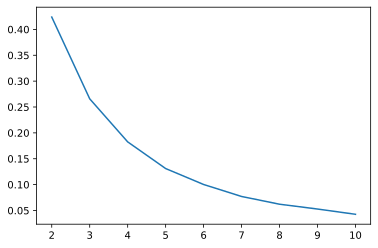

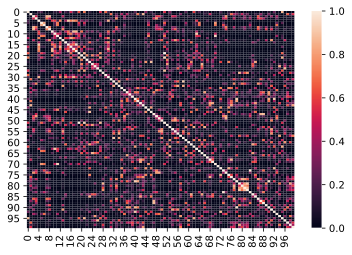

0
1
2
3
4
5
6
7
8
9


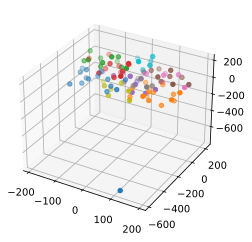

In [858]:
# paper figures/focus on siegle framing/new exclusion criteria
if not config.deploy_flag: 
    ccg_all = ccg_data['ccgn'][0][0].copy()
    ccg_curr = ccg_all.copy()
    ccg_curr_half = ccg_all.copy()
    
    noise_std = ccg_all['noise_std2']
    noise_mean = ccg_all['noise_mean2']
    subset = np.logical_and.reduce((noise_std>0, ccg_all['peaks']>7*noise_std + noise_mean, ccg_all['peak_lag']>=-10, ccg_all['peak_lag']<=10));
    
    test = np.transpose((np.arange(subset.shape[0]) % 2) == 0)   
    subset_half = np.logical_and(np.squeeze(subset), np.transpose(np.mod(np.arange(subset.shape[0]), 2) == 0))

    ccg_fields = ccg_data['ccgn'][0][0].dtype.names
    
    for field in ccg_fields:
        if field != 'config' and field != 'cluster':
            ccg_curr[field] = ccg_all[field][np.squeeze(subset)]
            ccg_curr_half[field] = ccg_all[field][np.squeeze(subset_half)]
    
    run_save_clustering(ccg_curr['ccgs'][0:100])
    plot_cluster_exploration()

In [76]:
# plotting functions
def plot_cluster_exploration():
    tsne_mtx, assoc_mtx, cluster_labels, k_idx, delta_k, assoc_mtxes = load_clustering()
    plt.plot(np.arange(2,11), delta_k)
    plt.show()
    sns.heatmap(assoc_mtx)
    plt.show()
    sns.clustermap(assoc_mtx)
    plt.show()

    fig=plt.figure()
    clusters = np.unique(cluster_labels)
    ax = plt.axes(projection ="3d")
    for i in clusters:
        print(i)
        ax.scatter3D(tsne_mtx[cluster_labels==i][:,0], tsne_mtx[cluster_labels==i][:,1], tsne_mtx[cluster_labels==i][:,2])
        
def plot_figure1(ccg_curr,ccg_curr_half, ccg_all):
    # plot 1 good example ccg (full range)
    ex_id = 195
    ex_ccg_control = ccg_curr['ccg_control'][ex_id]
    plt.figure(figsize=(2,2.66))
    plt.plot(np.arange(-100,101), ex_ccg_control, color='k',)
    plt.axvline(0, color='k', linestyle='dotted')
    plt.xlim((-100, 100))
    plt.xlabel('time lag (ms)')
    plt.ylabel('efficacy (coincidence per spike)')
    plt.gca().text(10, .01,'offset = ' + str(-int(ccg_curr['peak_lag'][ex_id])) + " ms")
    set_axis_defaults()
    plt.savefig('figures/python/fig1_ex_ccg.svg', dpi=300, bbox_inches='tight')
    plt.show()

    # plot dist. of noise_std vs # sig pairs 
    noise_std_above_mean = np.squeeze((ccg_all['peaks']-ccg_all['noise_mean2'])/ccg_all['noise_std2'])
    noise_std_above_mean = noise_std_above_mean[::2] # only select 1 direction of ccgs so that we are not double counting
    
    total_pairs = noise_std_above_mean.size
    pairs_within_10 = np.sum(np.logical_and(np.squeeze(ccg_all['peak_lag'][::2])>=-10, np.squeeze(ccg_all['peak_lag'][::2])<=10))

    noise_std_above_mean = noise_std_above_mean[np.logical_and.reduce((~np.isinf(noise_std_above_mean),
                                                                      ~np.isnan(noise_std_above_mean), 
                                                                       np.squeeze(ccg_all['peak_lag'][::2])>=-10, 
                                                                       np.squeeze(ccg_all['peak_lag'][::2])<=10))]

    plt.figure(figsize=(2,2.66))
    ecdf_calc = []
    for i in np.arange(7,20.1,.1):
            ecdf_calc.append(np.sum(noise_std_above_mean>i))
            
    sns.ecdfplot(x=noise_std_above_mean, stat='count', complementary=True, color='k')
    plt.xlim(0, 20)
    plt.ylabel("num. of pairs")
    plt.xlabel("> x std. above noise")
    plt.axvline(7, color='k', linestyle='solid')
    plt.gca().text(10, 20000,'all, n = ' + str(int(total_pairs)) + '\n'+
                   '|lag|<=10, n = ' + str(int(pairs_within_10)) + '\n'+
                   'sig., n = ' + str(int(np.sum(noise_std_above_mean>7))))
    plt.fill_between(np.arange(7,20.1,.1), ecdf_calc,color='#b8e0d2' )
    set_axis_defaults()
    plt.savefig('figures/python/fig1_sig_cdf.svg', dpi=300, bbox_inches='tight')
    plt.show()

    # plot time lag histogram among sig. ccgs
    lag = np.absolute(np.squeeze(ccg_curr_half['peak_lag']))

    plt.figure(figsize=(2,2.66))
    sns.histplot(x=lag,  color='#b8e0d2', bins=11, fill=True, element="step")
    plt.xlim(0, 10)
    plt.ylabel("num. of pairs")
    plt.xlabel("time lag (ms)")
    plt.axvline(np.nanmedian(lag), color='k', linestyle='--')
    plt.gca().text(4, 1000,'med. = ' + str(int(np.nanmedian(lag))))
    set_axis_defaults()
    plt.savefig('figures/python/fig1_lag_hist.svg', dpi=300, bbox_inches='tight')
    plt.show()

    # plot peak magnitude histogram among sig. ccgs
    peaks = np.absolute(np.squeeze(ccg_curr_half['peaks']))
    plt.figure(figsize=(2,2.66))
    sns.histplot(x=peaks,  color='#b8e0d2', bins=400,fill=True, element="step")
    plt.ylabel("num. of pairs")
    plt.xlabel("peak magnitude")
    plt.axvline(np.nanmedian(peaks), color='k', linestyle='--')
    plt.xlim(0,.05)
    plt.gca().text(.02, 800,'med. = ' + str(round(np.nanmedian(peaks), 3)))
    set_axis_defaults()
    plt.savefig('figures/python/fig1_peak_hist.svg', dpi=300, bbox_inches='tight')
    plt.show()
    
def plot_figure2(ccg_curr_half):
    data = pd.DataFrame({"peak magnitude": np.squeeze((ccg_curr_half['peaks'])),
                  "time lag (ms)": np.squeeze(np.abs(ccg_curr_half['peak_lag'])),
                  "pair distance ($\mu$m)": np.squeeze(ccg_curr_half['pair_distance']),
                  "$r_{ori}$": np.squeeze(ccg_curr_half['r_ori']), "put. cell type": np.squeeze(ccg_curr_half['pre_sc'])})

    #pair_grid = sns.pairplot(data, hue="put. cell type", corner=True, diag_kws={'common_norm': True},plot_kws={'scatter_kws':{'s':.5}})
    plt.figure(figsize=(3,3))
    y = "time lag (ms)"
    x = "pair distance ($\mu$m)"
    r, p = spearmanr(data[x],data[y])
    sns.regplot(data=data, y=y,order=2,x_bins=10, x=x,  color='k', truncate=True)
    #plt.gca().text( 400,4,'$n =$' + str(int(data.shape[0])) + ',\n$r_s =$ ' + str(round(r, 2)) + ',\n $p_s =$ ' + "{:.2e}".format(p))
    set_axis_defaults()
    plt.gca().set_xlim(0,1500)
    plt.savefig('figures/python/fig2_lag_vs_pd.svg', dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(3,3))
    y = "time lag (ms)"
    x = "$r_{ori}$"
    r, p = spearmanr(data[x],data[y])
    sns.regplot(data=data, y=y,order=2,x_bins=10, x=x, color='k', truncate=True)
    #plt.gca().text(.4,4, '$n =$' + str(int(data.shape[0])) + ',\n$r_s =$ ' + str(round(r, 2)) + ',\n $p_s =$ ' + "{:.2e}".format(p))
    set_axis_defaults()
    plt.gca().set_xlim(-.3,1)
    plt.savefig('figures/python/fig2_lag_vs_ori.svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(3,3))
    y = "peak magnitude"
    x = "pair distance ($\mu$m)"
    r, p = spearmanr(data[x],data[y])
    sns.regplot(data=data, y=y, x=x, fit_reg = False,x_bins=10, color='k',x_estimator=np.median, truncate=True, order=2)
    #plt.gca().text(1750,.02, '$n =$' + str(int(data.shape[0])) + ',\n$r_s =$ ' + str(round(r, 2)) + ',\n $p_s =$ ' + "{:.2e}".format(p))
    plt.gca().set_xlim(0,1500)
    plt.gca().set_ylim(0.01, 0.02)#plt.gca().get_xlim()[0], 1)
    set_axis_defaults()
    plt.savefig('figures/python/fig2_peak_vs_pd.svg', dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(3,3))
    y = "peak magnitude"
    x = "$r_{ori}$"
    r, p = spearmanr(data[x],data[y])
    sns.regplot(data=data, y=y,  fit_reg = False, x_bins=10,color='k',x=x,order=2,x_estimator=np.median, truncate=True)
    #plt.gca().text(-.7,.02, '$n =$' + str(int(data.shape[0])) + ',\n$r_s =$ ' + str(round(r, 2)) + ',\n $p_s =$ ' + "{:.2e}".format(p))
    #plt.gca().set_xlim(plt.gca().get_xlim()[0], 1)
    plt.gca().set_ylim(0.01, 0.02)#plt.gca().get_xlim()[0], 1)
    set_axis_defaults()
    plt.savefig('figures/python/fig2_peak_vs_ori.svg', dpi=300, bbox_inches='tight')
    plt.show()

def plot_figure2_ex(ccg_curr, ccg_all):
    ori_tuning = np.squeeze(ccg_curr['cluster'][0][0]['mean_ori_tune'])
    ses_3_tuning = ori_tuning

    ses_3_tuning = np.transpose(np.transpose(ses_3_tuning) - np.ndarray.min(ses_3_tuning, axis=1)) # subtract min, new min = 0
    one_over_range = 1/np.ptp(ses_3_tuning, axis=1)
    ses_3_tuning = ses_3_tuning*one_over_range[:,np.newaxis]     

    sim_idx1 = 446
    sim_idx2 = 409

    dif_idx1 = 65+121;
    dif_idx2 = 156+121;

    ori_tune_cell1 = ses_3_tuning[sim_idx1]
    ori_tune_cell2 = ses_3_tuning[sim_idx2]

    ori1_x, ori1_y = fit_von_mises(ori_tune_cell1)
    ori2_x, ori2_y = fit_von_mises(ori_tune_cell2)

    plt.figure(figsize=(6,6))
    plt.subplot(2,2,1)
    plt.plot(ori1_x, ori1_y, color='#809bc0', linestyle='solid')
    plt.plot(ori2_x, ori2_y, color='#ccffff', linestyle='solid')
    plt.plot(ori1_x, ori_tune_cell1, color='#809bc0', linestyle='None', marker='.')
    plt.plot(ori2_x, ori_tune_cell2, color='#ccffff', linestyle='None', marker='.')
    set_axis_defaults()
    plt.xlabel("orientation (deg)")
    plt.ylabel("firing rate (rescaled)")
    plt.gca().set_xticks([0,180])

    ori_tune_cell1 = ses_3_tuning[dif_idx1]
    ori_tune_cell2 = ses_3_tuning[dif_idx2]

    ori1_x, ori1_y = fit_von_mises(ori_tune_cell1)
    ori2_x, ori2_y = fit_von_mises(ori_tune_cell2)
    plt.subplot(2,2,2)
    plt.plot(ori1_x, ori1_y, color='#ffcaaf', linestyle='solid')
    plt.plot(ori2_x, ori2_y, color='#adf7b6', linestyle='solid')
    plt.plot(ori1_x, ori_tune_cell1, color='#ffcaaf', linestyle='None', marker='.')
    plt.plot(ori2_x, ori_tune_cell2, color='#adf7b6', linestyle='None', marker='.')
    set_axis_defaults()
    plt.gca().set_xticks([0,180])
    plt.ylabel("firing rate (rescaled)")
    plt.xlabel("orientation (deg)")

    plt.subplot(2,2,3)

    df = pd.DataFrame({'firing rate cell 1': ses_3_tuning[sim_idx1], 'firing rate cell 2': ses_3_tuning[sim_idx2]})
    sns.scatterplot(data=df, x='firing rate cell 1', y='firing rate cell 2', color='k')
    set_axis_defaults()
    plt.gca().text(.5, .4, '$r_{ori}$=' + str(round(float(ccg_all['r_ori'][np.logical_and(ccg_all['pre_id']==sim_idx1+1, ccg_all['post_id']==sim_idx2+1)]),2)), fontsize=12)

    plt.xlabel(plt.gca().get_xlabel(), color='#809bc0', bbox={'boxstyle': 'round', 'color':'k'})
    plt.ylabel(plt.gca().get_ylabel(), color='#ccffff',  bbox={'boxstyle': 'round', 'color':'k'})

    plt.subplot(2,2,4)
    df = pd.DataFrame({'firing rate cell 3': ses_3_tuning[dif_idx1], 'firing rate cell 4': ses_3_tuning[dif_idx2]})    
    sns.scatterplot(data=df, x='firing rate cell 3', y='firing rate cell 4', color='k')
    plt.gca().text(.5, .4, '$r_{ori}$=' + str(round(float(ccg_all['r_ori'][np.logical_and(ccg_all['pre_id']==dif_idx1+1, ccg_all['post_id']==dif_idx2+1)]),2)), fontsize=12)
    plt.tight_layout()

    plt.xlabel(plt.gca().get_xlabel(), color='#ffcaaf', bbox={'boxstyle': 'round', 'color':'k'})
    plt.ylabel(plt.gca().get_ylabel(), color='#adf7b6',  bbox={'boxstyle': 'round', 'color':'k'})

    set_axis_defaults()

    plt.savefig('figures/python/fig2_ex_signal_corr.svg', dpi=300, bbox_inches='tight')

    plt.show()    
    
def plot_figure3(ccg_curr):
    metrics = ["cl", "ct", "sc"]

    #
    for i in range(1):
        pre_lab = "pre_" + metrics[i]
        post_lab = "post_" + metrics[i]
        maxima = "peak"
        row_labels = labels[metrics[i]]
        num_rows = len(row_labels); 

        directionality_score = np.expand_dims(np.sum(ccg_curr['ccgs'][:,0:10], axis=1)-np.sum(ccg_curr['ccgs'][:,11:21], axis=1),1)
        cont_mtx = make_cont_mtx(ccg_curr[pre_lab], ccg_curr[post_lab], directionality_score, num_rows)
        df = pd.DataFrame(np.round(cont_mtx,3)*100, columns=row_labels, index=row_labels)

        plt.figure(figsize=(num_rows/1.4,num_rows/1.4))
        sns.heatmap(df, square=True,annot=False, cbar=True, cmap='vlag', center=0,linewidths=.2, cbar_kws={"shrink": .7}, linecolor='k', vmin=-4, vmax=4) #annot=True, 
        plt.xlabel('target', fontsize=14)
        plt.ylabel('source', fontsize=14)
        ax = plt.gca()
        plt.setp(ax.get_xticklabels(),Fontsize=14)
        plt.setp(ax.get_yticklabels(),Fontsize=14)
        plt.yticks(ax.get_yticks(),ax.get_yticklabels(),rotation='horizontal')
        plt.savefig('figures/python/fig3_direct_score' +metrics[i]+'.svg', dpi=300, bbox_inches='tight')

        #plt.title("directionality score, n = " + str(int(ccg_curr[pre_lab].size/2)))
        plt.show()
        if i==3:
            den = 1
        else:
            den = 1.4

        plt.figure(figsize=(num_rows/den,num_rows/1.4))
        cont_mtx = make_cont_mtx(ccg_curr[pre_lab][ccg_curr['peak_lag']==0], ccg_curr[post_lab][ccg_curr['peak_lag']==0], ccg_curr[maxima+'s'][ccg_curr['peak_lag']==0], num_rows)
        df = pd.DataFrame(cont_mtx, columns=row_labels, index=row_labels)

        g = sns.heatmap(df, square=True,annot=False, cbar=True,linewidths=.2, cbar_kws={"shrink": .7}, linecolor='k', vmin=0, vmax=.1) #annot=True, 
        #plt.xlabel('neuron k', fontsize=14)
        #plt.ylabel('neuron j', fontsize=14)
        g.set_facecolor('k')

        ax = plt.gca()
        plt.setp(ax.get_xticklabels(),Fontsize=14)
        plt.setp(ax.get_yticklabels(),Fontsize=14)
        plt.yticks(ax.get_yticks(),ax.get_yticklabels(),rotation='horizontal')
        #plt.title("directionality score, n = " + str(int(ccg_curr[pre_lab].size/2)))
        plt.savefig('figures/python/fig3_sync_mag' +metrics[i]+'.svg', dpi=300, bbox_inches='tight')
        plt.show()
        #data = pd.DataFrame({""})
        #sns.pairplot()

    i = 2
    pre_lab = "pre_" + metrics[i]
    post_lab = "post_" + metrics[i]
    maxima = "peak"
    row_labels = labels[metrics[i]]
    num_rows = len(row_labels); 
    plt.figure(figsize=(num_rows/den,num_rows/1.4))
  
    pre_labs = ccg_curr[pre_lab][ccg_curr['peak_lag']==0]
    post_labs = ccg_curr[post_lab][ccg_curr['peak_lag']==0]
    peaks = ccg_curr[maxima+'s'][ccg_curr['peak_lag']==0]
    simp_comp_label = np.chararray(peaks.size, peaks.size)
    for i in range(peaks.size):
        if pre_labs[i] == 1 and post_labs[i] == 1:
            simp_comp_label[i] = "complex, complex"
        elif pre_labs[i] == 1 and post_labs[i] == 2:
            simp_comp_label[i] = "simple, complex"
        elif pre_labs[i] == 2 and post_labs[i] == 1:
            simp_comp_label[i] ="simple, complex"
        elif pre_labs[i] == 2 and post_labs[i] == 2:
            simp_comp_label[i] = "simple, simple"
        else:
            ValueError("did you change simple/complex numbering?")
    df = pd.DataFrame({"labels": simp_comp_label, "peaks": peaks})
    sns.kdeplot(data=df, hue="labels")
    plt.xlabel('peaks', fontsize=14)
    
    ax = plt.gca()
    plt.setp(ax.get_xticklabels(),Fontsize=14)
    plt.setp(ax.get_yticklabels(),Fontsize=14)
    plt.yticks(ax.get_yticks(),ax.get_yticklabels(),rotation='horizontal')
    #plt.title("directionality score, n = " + str(int(ccg_curr[pre_lab].size/2)))
    plt.savefig('figures/python/fig3_sync_mag' +metrics[i]+'.svg', dpi=300, bbox_inches='tight')
    plt.show()
    #data = pd.DataFrame({""})
    #sns.pairplot()
   
    # plot example ccg with lag 0
    ex_id = 4830
    ex_ccg_control = ccg_curr['ccg_control'][ex_id]
    plt.figure(figsize=(2,2.66))
    plt.plot(np.arange(-100,101), ex_ccg_control, color='k',)
    plt.axvline(0, color='k', linestyle='--')
    plt.xlim((-100, 100))
    plt.xlabel('time lag (ms)')
    #plt.ylabel('efficacy (coincidence per spike)')
    plt.gca().text(10, .01,'offset = ' + str(-int(ccg_curr['peak_lag'][ex_id])) + " ms")
    set_axis_defaults()
    plt.gca().spines['left'].set_visible(False)
    plt.gca().set_yticks([])
    plt.savefig('figures/python/fig3_ex_syn_ccg.svg', dpi=300, bbox_inches='tight')
    plt.show()

    # plot example ccg with large assymetry
    ex_id = 4200
    ex_ccg_control = ccg_curr['ccg_control'][ex_id]
    plt.figure(figsize=(2,2.66))
    plt.plot(np.arange(-100,101), ex_ccg_control, color='k',)
    plt.axvline(0, color='k', linestyle='--')
    plt.xlim((-30, 30))
    plt.xlabel('time lag (ms)')
    #plt.ylabel('efficacy (coincidence per spike)')
    plt.gca().text(10, .01,'offset = ' + str(-int(ccg_curr['peak_lag'][ex_id])) + " ms")
    plt.gca().text(10, .02,labels['cl'][int(ccg_curr['pre_cl'][ex_id])] + ' -> ' + labels['cl'][int(ccg_curr['post_cl'][ex_id])])
    set_axis_defaults()
    plt.gca().spines['left'].set_visible(False)
    plt.gca().set_yticks([])
    plt.fill_between([0,1,2,3,4,5,6,7,8,9,10], ex_ccg_control[100:111], color='b')
    #plt.fill_between([6,7,8,9,10], y1=ex_ccg_control[107:112], y2=np.zeros(5))
    plt.fill_between([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1, 0], ex_ccg_control[90:101],color='r' )
    plt.axhline(0, color='k',linestyle='-.')
    plt.savefig('figures/python/fig3_ex_dir_ccg.svg', dpi=300, bbox_inches='tight')
    plt.show()

def plot_a2_shude(ccg_curr, ccg_all):
    subset = np.logical_and(ccg_curr['pre_sc'] == 2, ccg_curr['post_sc'] == 1)     
    ccg_curr_shude = ccg_curr.copy()
    for field in ccg_fields:
        if field != 'config' and field != 'cluster':
            ccg_curr_shude[field] = np.squeeze(ccg_curr[field][np.squeeze(subset)])
            ccg_all[field] = np.squeeze(ccg_all[field])
            ccg_curr[field] = np.squeeze(ccg_curr[field])

    # ccg_curr_shude['ccgs'] = ccg_curr_shude['ccgs'] + -np.min(ccg_curr_shude['ccgs'])

    lsum = np.sum(ccg_curr_shude['ccgs'][:, 5:10], axis = 1)
    rsum = np.sum(ccg_curr_shude['ccgs'][:, 11:16], axis = 1)
    ca = np.squeeze(lsum-rsum)/(np.squeeze(lsum+rsum))

    # make dataframe
    df = pd.DataFrame({'CA': ca, 
                      'pair distance': ccg_curr_shude['pair_distance'], 
                      'r_ori': ccg_curr_shude['r_ori'],
                     'session': ccg_curr_shude['session'],
                     'peak': ccg_curr_shude['peaks'],
                      'peak_lag': ccg_curr_shude['peak_lag'], 
                      'pre_id': ccg_curr_shude['pre_id']})
    all_df = pd.DataFrame({'r_ori': ccg_all['r_ori'],
                     'session': ccg_all['session'],
                     'peak': ccg_all['peaks']})
    sig_df = pd.DataFrame({'r_ori': ccg_curr['r_ori'],
                     'session': ccg_curr['session'],
                     'peak': ccg_curr['peaks']})
    
    # shude question 1
    # plot simple/complex correlation assymetry distribution (maybe use 5 instead of 10)
    # wts few pairs have CA<0, CA distribution has two peaks 
    # wts correlation between depth of complex cell and CA
    x='CA'
    include = np.logical_and.reduce((df[x]<=(1.5*scipy.stats.iqr(df[x]) + np.quantile(df[x], .75)),
                             df[x]>=(-1.5*scipy.stats.iqr(df[x]) + np.quantile(df[x], .25))))
    plt.figure()

    sns.histplot(data = df.loc[include], x='CA')
    plt.axvline(np.mean(df['CA']), color='k', linestyle='-.')
    plt.axvline(0, color='k', linestyle='-')
    plt.savefig('figures/python/shude_qs_hist.svg', dpi=300, bbox_inches='tight')

    #plt.show()

    plt.figure()
    df_comp_pre = df.loc[include]
    x = 'CA'
    y='pair distance'
    r, p = spearmanr(df_comp_pre[x],df_comp_pre[y])
    plt.gca().text(.005, .8, '$r_s =$ ' + str(round(r, 2)) + ',\n $p_s =$ ' + "{:.2e}".format(p))
    sns.regplot(data=df_comp_pre, x='CA', y='pair distance', order=2)
    plt.savefig('figures/python/shude_qs_comp_simp_depth.svg', dpi=300, bbox_inches='tight')
    plt.show()

    # shude question 2
    # peak vs diff in pref orientation ~r_ori
    # simple -> complex, simple-> simple, complex-> complex, complex -> simple
    # for each session + overall 

    sessions = [1,2,3]
    for i in sessions:
        x='CA'
        include = np.logical_and.reduce((df['session'] == i, df[x]<=(1.5*scipy.stats.iqr(df[x]) + np.quantile(df[x], .75)),
                             df[x]>=(-1.5*scipy.stats.iqr(df[x]) + np.quantile(df[x], .25))))

        sns.histplot(data = df.loc[include], x='CA')
        plt.axvline(np.mean(df.loc[include]['CA']), color='k', linestyle='-.')
        plt.axvline(0, color='k', linestyle='-')
        plt.title("session " + str(i))
        plt.savefig('figures/python/shude_qs_hist' + str(i) + '.svg', dpi=300, bbox_inches='tight')

        plt.show()

        x='r_ori'
        include = np.logical_and.reduce((df['session'] == i, df[x]<=(1.5*scipy.stats.iqr(df[x]) + np.quantile(df[x], .75)),
                             df[x]>=(-1.5*scipy.stats.iqr(df[x]) + np.quantile(df[x], .25))))

        sns.histplot(data = df.loc[include], x=x)
        plt.axvline(np.mean(df.loc[include][x]), color='k', linestyle='-.')
        plt.axvline(0, color='k', linestyle='-')
        plt.title("session " + str(i))
        plt.savefig('figures/python/shude_qsori_hist' + str(i) + '.svg', dpi=300, bbox_inches='tight')

        plt.show()
        include = all_df['session'] == i
        x='r_ori'
        sns.histplot(data = all_df.loc[include], x=x)
        plt.axvline(np.mean(all_df.loc[include][x]), color='k', linestyle='-.')
        plt.axvline(0, color='k', linestyle='-')
        plt.title("session " + str(i))
        plt.savefig('figures/python/shude_qsori_all_hist' + str(i) + '.svg', dpi=300, bbox_inches='tight')

        plt.show()
 
        include = sig_df['session'] == i
        x='r_ori'
        sns.histplot(data = sig_df.loc[include], x=x)
        plt.axvline(np.mean(sig_df.loc[include][x]), color='k', linestyle='-.')
        plt.axvline(0, color='k', linestyle='-')
        plt.title("session " + str(i))
        plt.savefig('figures/python/shude_qsori_sig_hist' + str(i) + '.svg', dpi=300, bbox_inches='tight')

        plt.show()
        
        x = 'peak'
        y = 'r_ori'
        include_simp_pre = np.logical_and.reduce((df[x]<=(1.5*scipy.stats.iqr(df[x]) + np.quantile(df[x], .75)),
                             df[x]>=(-1.5*scipy.stats.iqr(df[x]) + np.quantile(df[x], .25)), df['peak_lag']>0, df['session'] == i))
        df_simp_pre = df.loc[include_simp_pre]

        print("session" + str(i) + " simp pre/comp post in degree: " + str(np.sum(include_simp_pre)/((np.unique(df_simp_pre['pre_id']).size))))
        plt.figure()

        sns.regplot(data=df_simp_pre, x='peak', y='r_ori')
        plt.title("simple leads complex" + ", session=" + str(i))

        r, p = spearmanr(df_simp_pre[x],df_simp_pre[y])
        plt.gca().text(.005, .8, '$r_s =$ ' + str(round(r, 2)) + ',\n $p_s =$ ' + "{:.2e}".format(p))

        plt.xlim(0,0.03)
        plt.ylim(-.75,1)
        plt.savefig('figures/python/shude_qs' + str(i) + '.svg', dpi=300, bbox_inches='tight')
        plt.show()

        include_comp_pre = np.logical_and.reduce((df[x]<=(1.5*scipy.stats.iqr(df[x]) + np.quantile(df[x], .75)),
                             df[x]>=(-1.5*scipy.stats.iqr(df[x]) + np.quantile(df[x], .25)), df['peak_lag']<0, df['session'] == i))
        df_comp_pre = df.loc[include_comp_pre]

        plt.figure()
        print("session" + str(i) + " comp pre/simp post in degree: " + str(np.sum(include_comp_pre)/((np.unique(df_comp_pre['pre_id']).size))))
        sns.regplot(data=df_comp_pre, x_bins=1, x='peak', y='r_ori')
        plt.title("complex leads simple"+ ", session=" + str(i))
        plt.xlim(0,0.03)
        plt.ylim(-.75,1)
        r, p = spearmanr(df_comp_pre[x],df_comp_pre[y])
        plt.gca().text(.005, .8, '$r_s =$ ' + str(round(r, 2)) + ',\n $p_s =$ ' + "{:.2e}".format(p))
        plt.savefig('figures/python/shude_q' + str(i) + '.svg', dpi=300, bbox_inches='tight')
        plt.show()    

    # shude question 3
    # does 1 complex cell receive monosynaptic input from mult. simple cells 
    # avg. indegree from simple cell for complex cell vs avg. indegree for other combos
    
def figure2_plot_network(depths, mean_peaks, cell_layer, session_idx, ccg_curr):
    plt.figure(figsize=(8,6))

    xrand = np.random.randn(*depths.shape)
    pre_x = np.ones_like(depths)+xrand
    cell_layer = np.array([(labels['cl'][int(layer)-1] if ~np.isnan(layer) else np.nan) for layer in cell_layer])
    uq_ses = np.unique(session_idx)
    xdiv = 10
    xticks = []
    xticklabels = []
    for i in range(uq_ses.size):
        ses_id = session_idx == uq_ses[i]
        xticks.append(xdiv*i+1)
        xticklabels.append('session ' + str(i+1))
        sns.scatterplot(x = pre_x[ses_id] + xdiv*i, y = depths[ses_id], color='k', size=(mean_peaks[ses_id]), legend=False)
    """
    cmap = matplotlib.cm.get_cmap('bone')
    for idx, row in enumerate(ccg_curr['pre_id']):
        pre_idx = ccg_curr['pre_id'][idx]-1
        post_idx = ccg_curr['post_id'][idx]-1
        lag = np.abs(ccg_curr['peak_lag'][idx])
        if (ccg_curr['peak_lag'][idx]<0):
            temp = pre_idx
            pre_idx = post_idx
            post_idx = temp
        
        if not (ccg_curr['peak_lag'][idx] == 0):     
            #plt.plot([pre_x[pre_idx], post_x[post_idx]],[depths[pre_idx], depths[post_idx]], color=cmap((int(lag)/11*.8+.1)), linewidth=.1, label='_nolegend_')
    """
    plt.gca().set_xlim(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1]*1.1)
    ###plt.gca().legend(np.flip(np.append(labels['cl'], '_Hidden')), loc='upper right', frameon=False) 
    set_axis_defaults()
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().set_xticklabels(xticklabels)
    plt.gca().set_xticks(xticks)
    plt.ylabel("distance from probe tip ($\mu m$)")
    plt.savefig('figures/python/fig2_network.svg', dpi=300, bbox_inches='tight')

    plt.show()
    # lag -> color
    # peak -> line width 

def figure2_setup_network(ccg_curr_half):
    ccg_curr_half_t = ccg_curr_half.copy()
    session_idx = np.squeeze(ccg_curr_half_t['cluster'][0][0]['Cluster_session'])
    depths = np.squeeze(ccg_curr_half_t['cluster'][0][0]['Cluster_celldepth'])
    med_peaks = []
    for idx in range(ccg_curr_half_t['cluster'][0][0]['Cluster_session'].size):
        med_peaks.append(np.median(ccg_curr_half_t['peaks'][np.logical_or(ccg_curr_half_t['pre_id'] == idx+1,ccg_curr_half_t['post_id'] == idx+1)]))
    
    cell_layer = np.squeeze(ccg_curr_half_t['cluster'][0][0]['Cluster_celllayer'])

    figure2_plot_network(depths, np.array(med_peaks), cell_layer,session_idx,ccg_curr_half_t)



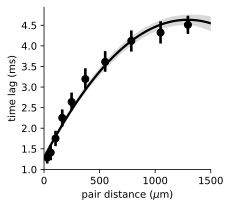

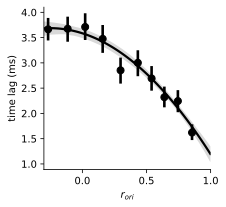

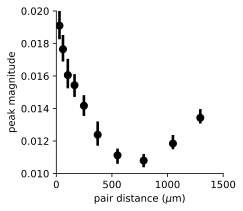

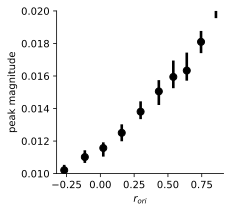

In [77]:
# paper figures/focus on siegle framing/new exclusion criteria
if not config.deploy_flag: 
    ccg_all = ccg_data['ccg'][0][0].copy()
    ccg_curr = ccg_all.copy()
    ccg_curr_half = ccg_all.copy()
    
    noise_std = ccg_all['noise_std2']
    noise_mean = ccg_all['noise_mean2']
    subset = np.logical_and.reduce((noise_std>0, ccg_all['peaks']>7*noise_std + noise_mean, ccg_all['peak_lag']>=-10, ccg_all['peak_lag']<=10));
    
    test = np.transpose((np.arange(subset.shape[0]) % 2) == 0)   
    subset_half = np.logical_and(np.squeeze(subset), np.transpose(np.mod(np.arange(subset.shape[0]), 2) == 0))

    ccg_fields = ccg_data['ccg'][0][0].dtype.names
    
    for field in ccg_fields:
        if field != 'config' and field != 'cluster':
            ccg_curr[field] = ccg_all[field][np.squeeze(subset)]
            ccg_curr_half[field] = ccg_all[field][np.squeeze(subset_half)]
            
    ## figure 1   
    #plot_figure1(ccg_curr,ccg_curr_half, ccg_all)
    
    ## figure 2
    plot_figure2(ccg_curr_half)
    #plot_figure2_ex(ccg_curr, ccg_all)
    #figure2_setup_network(ccg_curr_half)
    
    ## layer lead/lag, simple/complex lead/lag
    #plot_figure3(ccg_curr)
    #cluster.mean_ori_tune
    
    # shude questions computation
    #plot_a2_shude(ccg_curr, ccg_all)
    
    #run_save_clustering(ccg_curr['ccgs'][0:20])
    

In [769]:
# replicating https://www.biorxiv.org/content/10.1101/2020.08.30.272948v3.full.pdf
"""to do/differences notes:
-no resampling for consensus clustering
-fixed num_clusters as 3
-check that ses 1 was clustered correctly, unclear why it looks different 
""" 


def analyze_all_sessions(data, df):
    """ analyze_all_sessions computes clusters for each session
    :param data: ccg_data['ccgn'][0][0]
    :return df: pandas df augmented with clustering info
    """
    
    ses_dfs = pd.DataFrame(columns=['cluster_labels', 'conn_mtx', 'pca_mtx', 'assoc_mtx'])
    
    for ses_num in [1,2,3]:
        ses_idx = np.squeeze(data['session'] == ses_num)
        ccgs = data['ccgs'][ses_idx]
        pre_ids = data['pre_id'][ses_idx]
        post_ids = data['post_id'][ses_idx]
        
        conn_mtx = get_connectivity_matrix(ccgs, pre_ids, post_ids)
        pca_mtx = run_pca(conn_mtx)
        assoc_mtx = run_consensus_clustering(pca_mtx)
        cluster_labels = run_hierarchical_clustering(assoc_mtx)
        cluster_labels = reorder_by_connectivity(conn_mtx, cluster_labels)
        ses_df = df[df['session']==ses_num]
        
        ses_df['cluster_labels'] = [row for row in cluster_labels]
        ses_df['conn_mtx'] = [row for row in conn_mtx]
        ses_df['pca_mtx'] = [row for row in pca_mtx]
        ses_df['assoc_mtx'] = [row for row in assoc_mtx]
        
        ses_dfs = ses_dfs.append({'cluster_labels': cluster_labels, 'conn_mtx': conn_mtx, 'pca_mtx': pca_mtx, 'assoc_mtx': assoc_mtx}, ignore_index=True)
        
        if ses_num == 1:
            new_df = ses_df
        else:
            new_df = new_df.append(ses_df)
    return new_df, ses_dfs

def reorder_by_connectivity(conn_mtx, cluster_labels):
    labels = np.unique(cluster_labels)
    mean_connectivity = np.zeros(labels.size)
    for idx, label in enumerate(labels):
        mean_connectivity[idx] = np.nanmean(conn_mtx[cluster_labels==label])
    conn_sort_idx = np.argsort(mean_connectivity)
    cluster_labels = np.array([np.nonzero(conn_sort_idx == label) for label in cluster_labels])
    return cluster_labels

def get_connectivity_matrix(ccgs, pre_ids, post_ids):
    """ get_connectivity_matrix transforms raw ccgs into a connectivity matrix where each entry
    is the area under the CCG before zero subtracted from the area under the CCG after zero
    :param ccgs: ccgs is a num_pairs x 21 numpy array of ccgs
    :param pre_ids: pre_ids is a num_pairs numpy array where each entry is the id of the pre-synaptic neuron
    :param post_ids: post_ids is a num_pairs numpy array where each entry is the id of the post-synaptic neuron
    :return: conn_mtx - a num_neurons x num_neurons mtx
    """
    
    neu_ids = np.unique(pre_ids)
    conn_mtx = np.zeros((neu_ids.size, neu_ids.size))
    
    for pre_idx, pre_id in enumerate(neu_ids):
        for post_idx, post_id in enumerate(neu_ids):
            ccg = np.squeeze(ccgs[np.squeeze(np.logical_and(pre_ids == pre_id, post_ids == post_id))])
            conn_mtx[pre_idx, post_idx] = np.sum(ccg[:10])-np.sum(ccg[11:]) #0-9 - 11-20
            
    return conn_mtx
        
    
def run_pca(conn_mtx):
    """ run_pca runs pca with features as each row of the connectivity mtx and returns the first k pcs
    where k is the number of pcs neccesary to explain 80% variance in input data
    :param: conn_mtx - a num_neurons x num_neurons mtx
    :return: pca_mtx - a num_neurons x num_pcs mtx
    """
    pca_obj = PCA(n_components=conn_mtx.shape[0])
    pcs = pca_obj.fit_transform(conn_mtx)
    expl_var_for_k = np.cumsum(pca_obj.explained_variance_ratio_)
    k = np.argmax(expl_var_for_k>.8) + 1
    return pcs[:,:k]
    
def run_consensus_clustering(pca_mtx):
    """ run_consensus_clustering runs k-means 100 times with features as each row of the pca mtx
    to generate an association matrix (no resampling, num_clusters fixed at 3)
    :param: pca_mtx - a num_neurons x num_pcs mtx
    :return: assoc_mtx - a num_neurons x num_neurons mtx
    """    
    num_iters = 100
    num_neu = pca_mtx.shape[0]
    labels = np.zeros((100, num_neu))
    
    for i in range(num_iters):
        kmeans_obj = KMeans(n_clusters=3, init='random')
        labels[i] = kmeans_obj.fit_predict(pca_mtx)
    
    assoc_mtx = np.zeros((num_neu, num_neu))
    
    for pre_idx in range(num_neu):
        for post_idx in range(num_neu):
            for i in range(num_iters):
                assoc_mtx[pre_idx][post_idx] += labels[i][pre_idx] == labels[i][post_idx]
    
    assoc_mtx = assoc_mtx/num_iters
    return assoc_mtx
    
def run_hierarchical_clustering(assoc_mtx):
    """ run_hierarchical_clustering runs hierarchical clustering on the association matrix
    :param: assoc_mtx - a num_neurons x num_neurons mtx
    :return: cluster_labels - cluster assignment for each source neuron
    """
    cluster_obj = AgglomerativeClustering(n_clusters = 3, compute_full_tree = True, compute_distances=True)
    cluster_labels = cluster_obj.fit_predict(assoc_mtx)
    return cluster_labels


def get_converge_diverge(df, weight_std):
    ses_ns = df['session'].value_counts()
    divergence = np.zeros(df.shape[0])
    convergence = np.zeros(df.shape[0])

    for index, row in df.iterrows():
        ses_n = ses_ns[row['session']] # get number of neurons in a session
        convergence[index] = np.sum(row['conn_mtx']>weight_std)/(ses_n-1)
        divergence[index] = np.sum(row['conn_mtx']<weight_std)/(ses_n-1)

    df['convergence'] = convergence
    df['divergence'] = divergence
    return df

In [39]:
if not config.deploy_flag:
    data = ccg_data['ccgn'][0][0]
    cluster_data = data['cluster'][0][0]
    df = pd.DataFrame({'session': np.squeeze(cluster_data['Cluster_session']),
                  'celllayer': np.squeeze(cluster_data['Cluster_celllayer']),
                  'cell depth': np.squeeze(cluster_data['Cluster_celldepth']),
                   'celltype': np.squeeze(cluster_data['Cluster_celltype']), 
                  'MI_max': np.squeeze(cluster_data['Cluster_MI_max']), 
                  'simpcomp': np.squeeze(cluster_data['Cluster_simpcomp'])})

    df, ses_dfs = analyze_all_sessions(data, df)
    df.head()

<ipython-input-8-475525f8ceba>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ses_df['cluster_labels'] = [row for row in cluster_labels]
<ipython-input-8-475525f8ceba>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ses_df['conn_mtx'] = [row for row in conn_mtx]
<ipython-input-8-475525f8ceba>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [10]:
def plot_1e(ex_df, weight_std):
    ax = sns.heatmap(ex_df['conn_mtx'], cmap='vlag', vmin=-weight_std, vmax=weight_std)
    layer_center_idx = [0, 94, 100]
    layer_labels = ["lay", "lay", "lay"]
    ax.set_xticks(layer_center_idx)
    ax.set_yticks(layer_center_idx)
    ax.set_xticklabels(layer_labels)
    ax.set_yticklabels(layer_labels)
    ax.set_xlabel("target neurons")
    ax.set_ylabel("source neurons")
    plt.show()
    
def plot_1f(ex_df):
    assoc_mtx = ex_df['assoc_mtx']
    sns.clustermap(assoc_mtx, dendrogram_ratio = .1,figsize=(3,3), cbar_pos=(.05, .3, .03, .2))
    plt.show()
    
def plot_1g(example_ses, weight_std):
    sorted_example = example_ses.sort_values('cluster_labels')
    conn_mtx = np.stack(sorted_example['conn_mtx'].to_numpy(), axis=0)
    ax = sns.heatmap(conn_mtx, cmap='vlag', vmin=-weight_std, vmax=weight_std)
    layer_center_idx = [0, 94, 100]
    layer_labels = ["lay", "lay", "lay"]
    ax.set_xticks(layer_center_idx)
    ax.set_yticks([np.sum(example_ses['cluster_labels']<1), np.sum(example_ses['cluster_labels']<2), np.sum(example_ses['cluster_labels']<3)])
    ax.set_xticklabels(layer_labels)
    ax.set_yticklabels(["Cluster 1", "Cluster 2", "Cluster 3"])
    ax.set_xlabel("target neurons")
    ax.set_ylabel("source neurons")
    plt.show()
    
def plot_1h(example_ses, weight_std):
    idx = np.argsort(example_ses['cluster_labels'].to_numpy())
    conn_mtx = np.stack(example_ses['conn_mtx'].to_numpy(), axis=0)
    conn_mtx = conn_mtx[idx, :]
    conn_mtx = conn_mtx[:, idx]
    ax = sns.heatmap(conn_mtx, cmap='vlag', vmin=-weight_std, vmax=weight_std)
    cluster_pos = [np.sum(example_ses['cluster_labels']<1), np.sum(example_ses['cluster_labels']<2), np.sum(example_ses['cluster_labels']<3)]
    cluster_lab = ["Cluster 1", "Cluster 2", "Cluster 3"]
    ax.set_xticks(cluster_pos)
    ax.set_yticks(cluster_pos)
    ax.set_xticklabels(cluster_lab)
    ax.set_yticklabels(cluster_lab)
    ax.set_xlabel("target neurons")
    ax.set_ylabel("source neurons")
    plt.show()

def plot_2a(df, weight_std):
    for i in range(3):
        example_ses = df[df['session'] == i+1] # session 3
        plot_1h(example_ses, weight_std)

def plot_2b(all_clusters, all_conns):
    cluster_conn = pd.DataFrame({"Cluster": all_clusters, "Mean connectivity": all_conns})
    ax = sns.pointplot(x="Cluster", y="Mean connectivity", data=cluster_conn, join=False)
    plt.axhline(0, color='k', linestyle='--')
    plt.show()

def plot_3a(df):
    layers = np.unique(df['celllayer'])
    layers = layers[~np.isnan(layers)]
    sessions = np.unique(df['session'])
    prop_clust1 = []
    prop_clust3 = []
    temp_df = pd.DataFrame(columns=["layer", "prop", "cluster"])
    for idx, layer in enumerate(layers):
        denom_df = df.loc[df['celllayer'] == layer]
        numer_df1 = df.loc[np.logical_and.reduce((df['celllayer'] == layer,df['cluster_labels'] == 0))]
        numer_df2 = df.loc[np.logical_and.reduce((df['celllayer'] == layer,df['cluster_labels'] == 2))]

        denom = denom_df.shape[0]
        numer1 = numer_df1.shape[0]
        numer2 = numer_df2.shape[0] 

        temp_df = temp_df.append({'layer': labels['cl'][int(layer)-1],
                                  'prop': numer1/denom,
                                  'cluster': 'cluster 1'}, ignore_index=True)

        temp_df = temp_df.append({'layer': labels['cl'][int(layer)-1],
                                  'prop': numer2/denom, 
                                  'cluster': 'cluster 3'}, ignore_index=True)

    ax = sns.barplot(x="layer", y="prop", hue="cluster", data=temp_df)
    
def plot_3dto4c(df):
    df_sub = df[df['cluster_labels']!=1]
    df_sub.Clust.cat.remove_unused_categories(inplace=True)

    ax = sns.boxplot(x="Layer", y="convergence", hue="Clust",
                     data=df_sub, palette="crest")
    plt.show()
    ax = sns.boxplot(x="Layer", y="divergence", hue="Clust",
                     data=df_sub, palette="crest")
    plt.show()
    sns.kdeplot(
       data=df_sub, x="MI_max", hue="Clust",
       fill=True, common_norm=False, palette="crest",
       alpha=.5, linewidth=0,
    )
    plt.show()

    ax = sns.violinplot(x="Layer", y="MI_max", hue="Clust",
                        data=df_sub, palette="crest", split=True, cut=0)
    plt.show()
    
def plot_s4a(all_conns, weight_std):
    sns.histplot(all_conns)
    plt.xlim((-.1, .1))
    plt.axvline(weight_std, color='k', linestyle='--')
    plt.axvline(-weight_std, color='k', linestyle='--')
    plt.xlabel("connection weight values")
    plt.ylabel("num. pairs")

    set_axis_defaults()
    plt.show()

    

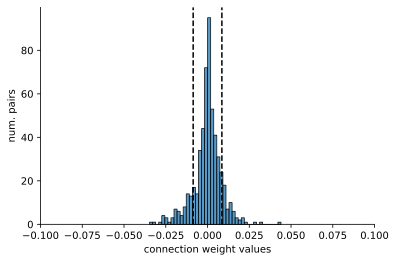

In [40]:
if not config.deploy_flag:
    all_conns = np.append(np.append(np.nanmean(np.array(ses_dfs.iloc[0]['conn_mtx']), axis=1),
                                    np.nanmean(np.array(ses_dfs.iloc[1]['conn_mtx']), axis=1)),
                                    np.nanmean(np.array(ses_dfs.iloc[2]['conn_mtx']), axis=1))
    all_clusters = np.append(np.append(ses_dfs.iloc[0]['cluster_labels'],ses_dfs.iloc[1]['cluster_labels']), ses_dfs.iloc[2]['cluster_labels'])+1

    weight_std = np.std(all_conns)
    df = get_converge_diverge(df, weight_std)

    cluster_labs = ['driver', 'neither', 'driven']
    layer_labels = [(labels['cl'][int(layer)-1] if ~np.isnan(layer) else np.nan) for layer in df['celllayer']]
    df['Layer'] = layer_labels
    df['Layer'] = df['Layer'].astype("category")

    put_labels = [(labels['ct'][int(layer)-1] if ~np.isnan(layer) else np.nan) for layer in df['celltype']]
    df['Put. type'] = put_labels
    df['Put. type'] = df['Put. type'].astype("category")

    func_labels = [(labels['sc'][int(layer)-1] if ~np.isnan(layer) else np.nan) for layer in df['simpcomp']]
    df['Func. type'] = func_labels
    df['Func. type'] = df['Func. type'].astype("category")

    clust_labels = [(cluster_labs[int(clust)]) for clust in df['cluster_labels']]
    df['Clust'] = clust_labels
    df['Clust'] = df['Clust'].astype("category")

    example_ses_df = ses_dfs.iloc[2]
    example_ses = df[df['session'] == 3] # session 3

    #plot_1e(example_ses_df, weight_std)
    #plot_1f(example_ses_df)
    #plot_1g(example_ses, weight_std)
    #plot_1h(example_ses, weight_std)
    plot_s4a(all_conns, weight_std)
    #plot_2a(df, weight_std)
    #plot_2b(all_clusters, all_conns)
    #plot_3a(df)
    #plot_3dto4c(df)

    #plot_5()
    #plot_5e()

    #plot_6()
    #plot_7()




In [12]:
#import holoviews as hv
#from holoviews import opts, dim
#from bokeh.sampledata.les_mis import data

if not config.deploy_flag:
    hv.extension('bokeh')
    hv.output(size=200)
    links = pd.DataFrame(data['links'])
    print(links.head(3))
    hv.Chord(links)

    nodes = hv.Dataset(pd.DataFrame(data['nodes']), 'index')
    nodes.data.head()
    chord = hv.Chord((links, nodes)).select(value=(5, None))
    chord.opts(
        opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
                   labels='name', node_color=dim('index').str()))

# Introduction


### 

# Correlated Neural Activity in Macaque V1
---

Welcome to the interactive analysis tool for *Functional Connectivity of Neurons within Single Cortical Columns Measured with Neuropixels*! 

This tool is designed to allow the community to explore a large dataset of Neuropixel recordings from macaque V1 and test hypotheses regarding functional connectivity among distinct layers and functional and putative cell types. 
## Tutorial 
1. Click on the 'Input Selection' page and browse the input selection options. If you're satisfied with the defaults used in the paper, click the 'plot' button on the right side of the page. Any time you change the inputs, you must click the plot button on this page to update the results. 
2. Click on the 'CCG examples' page and browse some example CCGs that were included with the selected inclusion criteria.  
3. Click on the '|Tau| Heatmap page'. The heatmaps displays mean |Tau| for pre-/post- layer pairs where the pre-synaptic layer is the row and the post-synaptic layer is the column. Most pages display both a main chart and pairwise comparisons/significance tests. Try changing the selected layers in the pairwise comparison input box and viewing the results in the histogram on the bottom right.
4. Click back on the 'Input Selection' page. On the 'Metric Input' tab, change the 'plot by' option from layer to functional cell type, then click the 'plot' button on the right side of the page. 
5. Click back on the '|Tau| Heatmap page'. Notice that the both the categories on the heatmap axes and in the pairwise comparison box have changed from layers to functional cell types. 
6. Browse the rest of the output pages and experiment with other input parameters. At a minimum, we recommend examining the three CCG metrics, 'plot by' options, removing the area exclusion criteria, and removing synchronous pairs (select $\tau$ range as 1-10). 


## Documentation 

### Input
####  CCG Metrics
We provide three CCG metrics that arise from applying different normalizatons to the raw cross-correlation. **Efficacy** is the proportion of pre-synaptic spikes followed by a post-synaptic spike.
**Contribution** is the proportion of post-synaptic spikes preceded by a pre-synaptic spike. **Geom. Mean** is the raw CCG normalized by the geometric mean of the firing rates of the pre- and post-synaptic neurons. More formally, theraw cross-correlation, $ CCG(\tau) $, is defined as follows:
$$ CCG(\tau) = \sum_{i=1}^M\sum_{t=\tau+1}^Nx_{pre}^i(t-\tau)\times x_{post}^i(t) $$
where $\tau$ is the time lag, $M$ is the number of trials, $N$ is the number of 1 ms time bins per trial, and $x_{pre(post)}^i(t)$ is 1 if the pre- (post-) synaptic neuron fired a spike in time bin t and 0 otherwise. 

Then, the efficacy CCG is defined as follows:
$$CCG(\tau)_{eff.} = \frac{ CCG(\tau)}{\sum_{i=1}^M\sum_{t-\tau+1}^Nx_{pre}^i(t-\tau)}$$

The contribution CCG is defined as follows:
$$CCG(\tau)_{contr.} = \frac{ CCG(\tau)}{\sum_{i=1}^M\sum_{t=\tau+1}^Nx_{post}^i(t)}$$

The geom. mean CCG is defined as follows:
$$CCG(\tau)_{g.m.}= \frac{ CCG(\tau)}{\sqrt{(\sum_{i=1}^M\sum_{t=\tau+1}^N x_{pre}^i(t-\tau))\times(\sum_{i=1}^M\sum_{t=\tau+1}^N x_{post}^i(t))}}$$

CCGs were corrected by subtracting the expected value of the CCG produced from jittered spike trains with a jitter window of 25 ms. The jitter method preserves spike train firing rates and PSTH within the 25 ms window. Thus, jitter-correction eliminates both stimulus-locked and long-timescale correlations.  

####  CCG Attributes
The **peak** is the maximum value of the corrected CCG. When examining peaks, $\tau$ is the time lag of the peak.

The **trough** is the minimum value of the corrected CCG. When examining troughs, $\tau$ is the time lag of the trough. 

The **area** is the integral under the CCG for $|\tau|<=10$. 

#### Exclusion Criteria 
We provide four exclusion criteria that can be used to subset CCGs into significant/non-significant divisions. 
1. CCGs that are greater than (less than) $k$ standard deviations above (below) the mean noise distribution are included to examine excitatory (inhibitory) interactions. The **noise distribution** is defined as either the entire CCG or the CCG 'tails' at $100>|\tau|>50$. $k$ and the noise distribution option is determined by user selection. 
2. CCGs with \tau inside of the range $\tau_1-\tau_2$ are included. $\tau_1, \tau_2$ are determined by user selection.
3. CCGs with area within a specific range are included.
4. CCGs that include neurons in a specific layer or with a specific functional or putative cell type are included.

#### Single Neuron Attributes
**Layer** refers to common layer divisions of macaque V1 including layers 2/3, 4a/b, 4c$\alpha$, 4c$\beta$, 5, 6, and WM. Layer divisions were determined based on CSD across the length of the probe. 

**Functional Cell Type** refers to simple vs complex cells. Simples cells have F1/F0 ratio greater than 1 and complex cells have F1/F0 ratio less than 1.

**Putative Cell Type** refers to axonal-spikes (AS), fast-spking (FS), regular-spiking medium (RM), and regular-spiking long (RL) divisions. These divisions are derived from waveform peak-trough difference as described in Zhu et al. 2021. 

### Output

#### Clustering
Significant CCGs are rescaled between 0 and 1. Then, PCA is run on rescaled CCGs with the value of CCGs at 11 (21) timepoints as  features. $x$ PCs are then used for aglommerative clustering with Ward linkage where $x$ is the number of PCs neccesary to explain 95% of variance in input data.

The optimal number of clusters used in the manuscript (3) was identified using a combination of silhouette criterion and within-cluster sums of squares. For efficiency, the number of clusters in the tool is fixed at 3, and if the number of significant CCGs exceeds 10,000, a random subset of 10,000 significant CCGs is used for clustering.
  

<center>
<img src='https://static.wixstatic.com/media/2997bf_9718a381f05f4cc9a721428ad26c6639~mv2.jpeg/v1/crop/x_35,y_47,w_1223,h_614/fill/w_388,h_195,al_c,q_80,usm_0.66_1.00_0.01/Image%207-17-20%20at%203_45%20PM.webp'>
<center>

# Input Selection

## Column

In [13]:
# code
default_label = widgets.Label(value="Default settings:")
default_selection = widgets.RadioButtons(
    options=[('s.d. (smith/kohn)', 'sd'),('s.d.+area (ours)', 'sd_area')],
    value='sd_area',
    disabled=False
)
default_button = widgets.Button(
    description='reset to defaults',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    icon='check' # (FontAwesome names without the `fa-` prefix)
)


plot_button = widgets.Button(
    description='plot', 
    disabled=False,
)

ccg_label = widgets.Label(value="Metric:")
ccg_selection = widgets.RadioButtons(
    options=[('Efficacy', 'ccg'),('Contribution', 'ccgpren'), ('Geom. mean','ccgn')],
    value='ccg',
    disabled=False
)
maxima_label = widgets.Label(value="Maxima:")
maxima_selection = widgets.RadioButtons(
    options=[('Peaks', 'peak'), ('Troughs', 'trough')],
    value='peak',
    disabled=False
)
noise_label = widgets.Label(value="Noise Distribution:")
noise_selection = widgets.RadioButtons(
    options=[('CCG (0-100 ms)', ''),('CCG tail (50-100 ms)', '2')],
    value='',
    disabled=False,
)
std_label = widgets.Label(value="Maxima > or < k std. + mean noise:")
std_selection = widgets.FloatRangeSlider(
    value=[3, 10],
    min=-10.0,
    max=10.0,
    step=0.1,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
lag_label = widgets.Label(value="Tau:")
lag_selection = widgets.IntRangeSlider(
    value=[0, 10],
    min=0,
    max=10,
    step=1,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
area_label = widgets.Label(value="CCG integral over |Tau|=0-10:")
area_selection = widgets.FloatRangeSlider(
    value=[.05, .5],
    min=-.5,
    max=.5,
    step=.001,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

cl_label = widgets.Label(value="Layer:")
cl_checkboxes = [widgets.Checkbox(value=True, indent=True, description=label) for label in labels['cl']]
cl_checkboxes[6].value = False; # don't include WM in default layers
cl_checkboxes.insert(0,cl_label);
cl_selection = widgets.VBox(children=cl_checkboxes)

ct_label = widgets.Label(value="Putat. type:")
ct_checkboxes = [widgets.Checkbox(value=True, indent=True, description=label) for label in labels['ct']]
ct_checkboxes.insert(0,ct_label);
ct_selection = widgets.VBox(children=ct_checkboxes)

sc_label = widgets.Label(value="Func. type:")
sc_checkboxes = [widgets.Checkbox(value=True, indent=True, description=label) for label in labels['sc']]
sc_checkboxes.insert(0,sc_label);
sc_selection = widgets.VBox(children=sc_checkboxes)
ex_selection = widgets.HBox([cl_selection, ct_selection, sc_selection])

plot_label = widgets.Label(value="Plot By:")
plot_selection = widgets.RadioButtons(
    options=[('Layer', 'cl'), ('Putative cell type', 'ct'), ('Functional cell type', 'sc')],
    value='cl',
    disabled=False
)

slide_ex_label = widgets.Label(value="Sliders determine which CCGs to include in the analysis, e.g., selecting a range for Tau of 1-10 means CCGs with Tau = 0 are excluded.")
check_ex_label = widgets.Label(value="Checkboxes determine which neurons to include in the analysis, e.g., checking W.M. means neurons in white matter will be included in figures.")





### Metric Input

In [14]:
# ignore for now widgets.VBox([default_label, default_selection, default_button]),
widgets.HBox([
              widgets.VBox([ccg_label, ccg_selection]), 
              widgets.VBox([maxima_label, maxima_selection]),
              widgets.VBox([noise_label, noise_selection]),
              widgets.VBox([plot_label, plot_selection])])


### CCG Subset

In [15]:
widgets.VBox([widgets.VBox([slide_ex_label, std_label, std_selection,lag_label,lag_selection, area_label, area_selection]),
              widgets.VBox([check_ex_label, ex_selection])])

In [16]:
data = ccg_data['ccg'][0][0]['cluster'][0][0]
df = pd.DataFrame({'session': np.squeeze(data['Cluster_session']),
              'celllayer': np.squeeze(data['Cluster_celllayer']),
              'cell depth': np.squeeze(data['Cluster_celldepth']),
               'celltype': np.squeeze(data['Cluster_celltype']), 
              'MI_max': np.squeeze(data['Cluster_MI_max']), 
              'simpcomp': np.squeeze(data['Cluster_simpcomp'])})

def on_layer_change(change):
    depth = data['Cluster_celldepth']
    new_layers = np.sum(depth<l23.value,depth<l4ab.value,depth<l4ca.value,depth<l4cb.value,depth<l5.value,depth<l6.value,depth<lWM.value)
    new_layers[new_layers==0] = float("NaN")
    
def layer_picker_output(ses_num):
    df_ses1 = df[df["session"]==ses_num]

    y = []
    for i in range(len(labels['cl'])):
        y.append(np.max(np.squeeze(data['Cluster_celldepth'])
                        [np.squeeze(np.logical_and(data['Cluster_session']==ses_num,data['Cluster_celllayer']==(i+1)))]));

    l23=widgets.IntSlider(value=int(y[0]), min=0, max=3000,description=labels['cl'][0], continuous_update=False)
    l4ab=widgets.IntSlider(value=int(y[1]), min=0, max=3000,description=labels['cl'][1], continuous_update=False)
    l4ca=widgets.IntSlider(value=int(y[2]), min=0, max=3000,description=labels['cl'][2], continuous_update=False)
    l4cb=widgets.IntSlider(value=int(y[3]), min=0, max=3000,description=labels['cl'][3], continuous_update=False)
    l5=widgets.IntSlider(value=int(y[4]), min=0, max=3000,description=labels['cl'][4], continuous_update=False)
    l6=widgets.IntSlider(value=int(y[5]), min=0, max=3000,description=labels['cl'][5], continuous_update=False)
    lWM=widgets.IntSlider(value=int(y[6]), min=0, max=3000,description=labels['cl'][6], continuous_update=False)
    ui = widgets.VBox([l23, l4ab, l4ca,l4cb, l5, l6,lWM])

    def plot_layer_lines(l23, l4ab, l4ca, l4cb, l5, l6, lWM):
        plt.figure(2)
        ax1 = sns.kdeplot(data=df_ses1, y="cell depth", hue="simpcomp", fill=False, cut=0, bw_adjust=.4)
        ax1_lim = ax1.get_xlim()
        ax1.set_xlim((ax1_lim[0],2*ax1_lim[1])) 
        plt.legend(labels['sc'], frameon=False,loc='upper left')
        plt.xticks([])
        plt.xlabel('')
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)


        ax2 = ax1.twiny()
        sns.kdeplot(data=df_ses1, y="cell depth", hue="celltype",fill=False, ax=ax2, cut=0, bw_adjust=.4)
        ax2_lim = ax2.get_xlim()
        ax2.set_xlim((ax2_lim[0]-ax2_lim[1],ax2_lim[1])) 
        plt.legend(labels['ct'], frameon=False, loc='upper center')
        plt.xticks([])
        plt.xlabel('')
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)

        layer_min = []
        x_vals = []
        layer_lab = []
        ax3 = ax1.twiny()

        for i in range(len(labels['cl'])):
            if i == 0:
                y = l23
            elif i == 1:
                y = l4ab
            elif i == 2:
                y = l4ca
            elif i == 3:
                y = l4cb
            elif i == 4:
                y = l5
            elif i == 5:
                y = l6
            elif i == 6:
                y = lWM

            layer_min.append(y)
            layer_min.append(y)
            layer_lab.append(labels['cl'][i])
            layer_lab.append(labels['cl'][i])
            x_vals.append(ax3.get_xlim()[0])
            x_vals.append(ax3.get_xlim()[1])

        df_layer = pd.DataFrame({'x': x_vals, 'y': layer_min, 'layer_lab':layer_lab})

        sns.lineplot(data=df_layer, x='x', y='y', hue='layer_lab', ax=ax3, palette="crest" )
        plt.legend(labels['cl'], frameon=False, loc='upper right')
        plt.xticks([])
        plt.xlabel('')
        ax3.spines['right'].set_visible(False)
        ax3.spines['top'].set_visible(False)
        ax3.spines['bottom'].set_visible(False)
        ax3.set_ylim(ax3.get_ylim()[0], ax3.get_ylim()[1]*1.5)

        plt.show()


    output = interactive_output(plot_layer_lines, {'l23':l23,
                                                      'l4ab':l4ab,
                                                      'l4ca':l4ca,
                                                      'l4cb':l4cb,
                                                      'l5':l5,
                                                      'l6':l6,
                                                      'lWM':lWM})

    out_layer = widgets.Output()



    display(widgets.HBox([ui,output]))

### Ses. 1 Layer

In [17]:
layer_picker_output(1)



### Ses. 2 Layer

In [18]:
layer_picker_output(2)


### Ses. 3 Layer

In [19]:
layer_picker_output(3)

## Column 

### Click here to plot!

In [20]:
display(plot_button)

Button(description='plot', style=ButtonStyle())

In [21]:
# code
pre_pair_label = widgets.Label(value="Pre:")
pre_opt = [(label, idx+1) for idx, label in enumerate(labels[plot_selection.value])]
pre_pair_selection = widgets.RadioButtons(
    options=pre_opt,
    value=pre_opt[0][1],
    disabled=False
)
post_pair_label = widgets.Label(value="Post:")
post_opt =  [(label, idx+1) for idx, label in enumerate(labels[plot_selection.value])]
post_pair_selection = widgets.RadioButtons(
    options=post_opt,
    value=post_opt[0][1],
    #layout={'width': 'max-content'},
    disabled=False
)

In [22]:
out0 = widgets.Output()
out0s = widgets.Output()

out = widgets.Output()
outs = widgets.Output()
outsi = widgets.Output()

out2 = widgets.Output()
out2s = widgets.Output()
out2si = widgets.Output()

out3 = widgets.Output()
out3s = widgets.Output()
out3si = widgets.Output()

out4 = widgets.Output()
out4s = widgets.Output()
out4si = widgets.Output()

out5 = widgets.Output()


def on_value_change(change):
    ccg_curr, maxima, metric, subset  = get_subset(change)
    plot_type = plot_selection.value;
    row_labels = labels[plot_type]
    num_rows = len(row_labels);
    pre_lab = "pre_" + plot_type
    post_lab = "post_" + plot_type
    
    with out0: 
        ex_ccgs = ccg_curr['ccgs']
        ex_idxes = np.random.choice(ex_ccgs.shape[0], size = 4, replace=True)
        
        out0.clear_output(wait=False)
        for idx, example in enumerate(ex_idxes):
            plt.subplot(2,2,idx+1)
            h = plt.plot(range(-10, -10 + ex_ccgs[example].size),ex_ccgs[example], 'o-')
            if idx>1:
                plt.xlabel("tau")
            if idx == 0 or idx == 2:
                plt.ylabel(metric)
            plt.tight_layout()
                
        plt.show()
        
    with out:
        cont_mtx = make_cont_mtx(ccg_curr[pre_lab], ccg_curr[post_lab], ccg_curr[maxima+'_lag'], num_rows)
        df = pd.DataFrame(cont_mtx, columns=row_labels, index=row_labels)
        
        out.clear_output(wait=False)
        sns.heatmap(df, annot=True, square=True)
        plt.xlabel('post-syn. neuron')
        plt.ylabel('pre-syn. neuron')
        plt.title("mean lead (ms), n = " + str(ccg_curr[pre_lab].size))
        plt.show()
    
    with out2:
        cont_mtx = make_cont_mtx(ccg_curr[pre_lab], ccg_curr[post_lab], ccg_curr[maxima+'s'], num_rows)
        df = pd.DataFrame(cont_mtx, columns=row_labels, index=row_labels)
        
        out2.clear_output(wait=False)
        sns.heatmap(df, cmap='YlOrBr', annot=True, square=True)
        plt.xlabel('post-syn. neuron')
        plt.ylabel('pre-syn. neuron')
        plt.title("mean maxima (ms), n = " + str(ccg_curr[pre_lab].size))
        plt.show()
        
    with out3:
        mtx, numer, denom = make_prop_mtx(ccg_curr[pre_lab], ccg_curr[post_lab], ccg_curr['peak_lag']>-1, num_rows)
        prop_mtx = np.divide(numer, numer + np.transpose(numer));
        df = pd.DataFrame(prop_mtx, columns=row_labels, index=row_labels)
        
        out3.clear_output(wait=False)
        sns.heatmap(df, cmap='vlag', center=.5, annot=True, square=True) #, annot=True
        plt.xlabel('neuron k')
        plt.ylabel('neuron j')
        plt.title("prop. j leads k, n = " + str(ccg_curr[pre_lab].size))
        plt.show()
    
    with out4:
        ccg_pre_subset = ccg_data[metric][0][0].copy()
        mtx, numer, denom = make_prop_mtx(ccg_pre_subset[pre_lab], ccg_pre_subset[post_lab], subset, num_rows)
        df = pd.DataFrame(mtx, columns=row_labels, index=row_labels)
        
        out4.clear_output(wait=False)
        sns.heatmap(df, cmap='YlOrBr', annot=True, square=True) #, annot=True
        plt.xlabel('neuron k')
        plt.ylabel('neuron j')
        plt.title("prop. sig, n = " + str(ccg_curr[pre_lab].size) + "/" + str(ccg_pre_subset[pre_lab].size))
        plt.show()
    
    with out5:
        ccg_fields = ccg_data['ccg'][0][0].dtype.names
        ccgs = ccg_curr['ccgs']
        
        out5.clear_output(wait=False)
        """subset, smoothed, cluster_obj = cluster_flow(ccgs)

        for field in ccg_fields:
            if field != 'config' and field != 'cluster' and field != 'ccg_control':
                ccg_curr[field] = ccg_curr[field][np.squeeze(subset)]

        #plot_cluster_network(cluster_obj.labels_, ccg_curr)
        plot_cluster_examples(smoothed, cluster_obj.labels_+1)
        plot_cluster_templates(smoothed, cluster_obj.labels_+1)
        #plot_cluster_bars()
        plot_dendrogram(cluster_obj, truncate_mode='level', p=3)
        plot_cluster_heatmaps(cluster_obj.labels_, ccg_curr, 'pre_cl', 'post_cl', len(labels['cl']), labels['cl'])
        """
    on_pairwise_change(change)

def on_metric_change(change):
    metric = ccg_selection.value
    maxima = maxima_selection.value
    ccg_curr = ccg_data[metric][0][0].copy()

    maxima_val = ccg_curr[maxima+'s']
    maxima_noise = ccg_curr['noise_std' + noise_selection.value]
    maxima_noise_mean = ccg_curr['noise_mean'+ noise_selection.value]
    maxima_area = np.squeeze(ccg_curr['area'])

    sd_inclusion = np.squeeze((maxima_val-maxima_noise_mean)/maxima_noise);
    
    nan_mask = np.logical_or.reduce((np.isnan(sd_inclusion), np.isnan(maxima_area), np.isinf(sd_inclusion), np.isinf(maxima_area)))
    xrange_mask = np.logical_and(sd_inclusion<=10, sd_inclusion>=0)
    yrange_mask = np.logical_and(maxima_area>=-.1, maxima_area<=.1)
    data_mask = np.logical_and.reduce((~nan_mask, xrange_mask, yrange_mask))
    
    with out0s:
        out0s.clear_output(wait=False)
        fig = sns.jointplot(x=sd_inclusion[data_mask], y=maxima_area[data_mask], kind='hist',dropna=True, xlim=(0, 10), ylim=(-.1, .1))     
        fig.set_axis_labels("x SDs above noise mean","ccg area")
        plt.show()
        
def on_plot_type_change(change):        
    plot_type = plot_selection.value;    
    pre_opt = [(label, idx+1) for idx, label in enumerate(labels[plot_type])]
    pre_pair_selection.value = pre_opt[0][1]
    pre_pair_selection.options = pre_opt
    
    post_opt = [(label, idx+1) for idx, label in enumerate(labels[plot_type])]
    post_pair_selection.value = post_opt[0][1]
    post_pair_selection.options = post_opt
    
    with outsi:
        outsi.clear_output(wait=False)
        display(widgets.HBox([widgets.VBox([pre_pair_label, pre_pair_selection]), widgets.VBox([post_pair_label, post_pair_selection])]))
    
    with out2si:
        out2si.clear_output(wait=False)
        display(widgets.HBox([widgets.VBox([pre_pair_label, pre_pair_selection]), widgets.VBox([post_pair_label, post_pair_selection])]))
    
    with out3si:
        out3si.clear_output(wait=False)
        display(widgets.HBox([widgets.VBox([pre_pair_label, pre_pair_selection]), widgets.VBox([post_pair_label, post_pair_selection])]))

    with out4si:
        out4si.clear_output(wait=False)
        display(widgets.HBox([widgets.VBox([pre_pair_label, pre_pair_selection]), widgets.VBox([post_pair_label, post_pair_selection])]))
        
    on_pairwise_change(change)

def on_pairwise_change(change):
    ccg_curr, maxima, metric, subset  = get_subset(change)
    plot_type = plot_selection.value;
    row_labels = labels[plot_type]
    num_rows = len(row_labels);
    pre_lab = "pre_" + plot_type
    post_lab = "post_" + plot_type
    
    pre_to_post = np.squeeze(np.logical_and(ccg_curr[pre_lab] == pre_pair_selection.value, ccg_curr[post_lab] ==post_pair_selection.value))
    post_to_pre = np.squeeze(np.logical_and(ccg_curr[post_lab] == pre_pair_selection.value, ccg_curr[pre_lab] ==post_pair_selection.value))
    conx_labels = {1: "pre->post", 2: "post->pre", 0: "other"}        

    with outs:
        lag = np.squeeze(ccg_curr[maxima+'_lag'])
        connection = pd.Categorical(np.append(pre_to_post, 2*post_to_pre)).rename_categories(conx_labels)
        lag = np.append(lag, lag)
        df = pd.DataFrame({'lead':lag, 'connection':connection})
        
        outs.clear_output(wait=False)
        sns.histplot(data=df, x='lead', hue="connection", stat="density", common_norm=False, fill=False)
        plt.show()
    
    with out2s:   
        lag = np.squeeze(ccg_curr[maxima+'s'])
        lag = np.append(lag, lag)
            
        connection = pd.Categorical(np.append(pre_to_post, 2*post_to_pre)).rename_categories(conx_labels)
        df = pd.DataFrame({maxima:lag, 'connection':connection})
        
        out2s.clear_output(wait=False)
        sns.histplot(data=df, x=maxima, hue="connection", stat="density", common_norm=False, fill=False)
        plt.show()
        
    with out3s:
        data = np.append(-1*ccg_curr[maxima+'_lag'][pre_to_post], ccg_curr[maxima+'_lag'][post_to_pre])
        data = data[data!=0]
        out3s.clear_output(wait=False)
        tstat, p = ttest_1samp(np.append(-1*ccg_curr[maxima+'_lag'][pre_to_post], ccg_curr[maxima+'_lag'][post_to_pre]) ,0)
        sns.histplot(x=data, stat="density", fill=False, bins=21)
        print("ttest = " + str(tstat) + ", p = " + str(p))
        plt.show()
        
    with out4s:
        ccg_pre_subset = ccg_data[metric][0][0].copy()
        all_pre_to_post = np.squeeze(np.logical_and(ccg_pre_subset[pre_lab] == pre_pair_selection.value, ccg_pre_subset[post_lab] ==post_pair_selection.value))
        all_post_to_pre = np.squeeze(np.logical_and(ccg_pre_subset[post_lab] == pre_pair_selection.value, ccg_pre_subset[pre_lab] ==post_pair_selection.value))
  
        sig_notsig = np.zeros((2,2))
        sig_notsig[0,0] =  np.sum(pre_to_post) # sig + pre->post
        sig_notsig[0,1] =  np.sum(all_pre_to_post)-np.sum(pre_to_post)# notsig + pre->post
        sig_notsig[1,0] =  np.sum(post_to_pre) # sig + post->pre
        sig_notsig[1,1] =  np.sum(all_post_to_pre)-np.sum(post_to_pre)# notsig + post-> pre
        
        g, p, dof, expctd = chi2_contingency(sig_notsig)
        
        out4s.clear_output(wait=False)
        
        print("Chi^2 test: chi^2 = " + str(g) + " p = " + str(p))

def on_click_reset(change):
    if default_selection.value == "sd_area":
        plot_selection.value = 'cl'
        ccg_selection.value = 'ccg'
        maxima_selection.value = 'peak'
        area_selection.value = (.05,.5)
        lag_selection.value = (0,10)
        std_selection.value = (3,10)
    elif default_selection.value == "sd":
        plot_selection.value = 'cl'
        ccg_selection.value = 'ccgn'
        maxima_selection.value = 'peak'
        area_selection.value = (-.5,.5)
        lag_selection.value = (0,10)
        std_selection.value = (5,10)
    else:
        error("wrong")

#for cbox in ct_checkboxes:
#    cbox.observe(on_value_change, names="value")
#for cbox in cl_checkboxes:
#    cbox.observe(on_value_change, names="value")
#for cbox in sc_checkboxes:
#    cbox.observe(on_value_change, names="value")


#plot_selection.observe(on_value_change, names="value")
#ccg_selection.observe(on_value_change, names="value")
#noise_selection.observe(on_value_change, names="value")
#maxima_selection.observe(on_value_change, names="value")
#area_selection.observe(on_value_change, names="value")
#lag_selection.observe(on_value_change, names="value")
#std_selection.observe(on_value_change, names="value")

plot_button.on_click(on_value_change)

plot_selection.observe(on_plot_type_change, names="value")

pre_pair_selection.observe(on_pairwise_change, names="value")
post_pair_selection.observe(on_pairwise_change, names="value")

ccg_selection.observe(on_metric_change, names="value")
maxima_selection.observe(on_metric_change, names="value")

default_button.on_click(on_click_reset)

# CCG Examples

## Column 1

### Output

In [23]:
on_value_change(None)
out0

Output()

## Column 2


### Output

In [24]:
on_metric_change(None)
out0s

<ipython-input-22-746195dce5cd>:123: RuntimeWarning: invalid value encountered in true_divide
  sd_inclusion = np.squeeze((maxima_val-maxima_noise_mean)/maxima_noise);


Output()

# |Tau| Heatmap

## Column 1

### Output

In [25]:
out

Output()

## Column 2

### Pairwise Test Input


In [26]:
on_plot_type_change(None)
outsi

Output()

### Pairwise Test Output

In [27]:
outs


Output()

# Maxima Heatmap

## Column 1

### Output

In [28]:
out2

Output()

## Column 2

### Pairwise Test Input

In [29]:
out2si

Output()

### Pairwise Test Output

In [30]:
out2s

Output()

# Prop. j leads k Heatmap

## Column 1

### Output

In [31]:
out3

Output()

## Column 2

### Pairwise Test Input

In [32]:
out3si

Output()

### Pairwise Test Output

In [33]:
out3s

Output()

# Prop. significant

## Column 1

### Output

In [34]:
out4

Output()

## Column 2

### Pairwise Test Input

In [35]:
out4si

Output()

### Pairwise Test Output

In [36]:
out4s

Output()

# Clustering

## Column

### Cluster Output

In [37]:
out5

Output()